# Getting Started with Together Code Interpreter (TCI)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Together_Code_Interpreter.ipynb)

This notebook demonstrates the capabilities of the Together Code Interpreter (TCI). 

TCI allows you to execute code (Python and shell commands) within a secure, sandboxed environment provided by Together AI.

You can use it for tasks like data analysis, visualization, running scripts, and more, optionally maintaining state across multiple code executions using sessions and interacting with uploaded files.

### Setup

First, we install the necessary libraries: `together` to interact with the Together AI platform and `pandas` which will be used in a later data analysis example.

In [ ]:
!pip install together pandas

Next, we import the `Together` client class and initialize it. By default, it uses the `TOGETHER_API_KEY` environment variable for authentication.

In [2]:
from together import Together

client = Together()

# Create a code interpreter instance
code_interpreter = client.code_interpreter

### Example 1: Simple print statement

In [3]:
# Example 1: Simple print statement
print("Example 1: Simple print")

# Run a simple print statement in the code interpreter
response = code_interpreter.run(code='print("Welcome to Together Code Interpreter!")', language="python")


print(f"Status: {response.data.status}")


for output in response.data.outputs:
    print(f"{output.type}: {output.data}")


if response.data.errors:
    print(f"Errors: {response.data.errors}")

Example 1: Simple print
Status: completed
stdout: Welcome to Together Code Interpreter!



### Example 2: Using session for maintaining state

In [4]:
# set a variable x to 42
response1 = code_interpreter.run(code="x = 42", language="python")

session_id = response1.data.session_id

# print the value of x
response2 = code_interpreter.run(
    code='print(f"The value of x is {x}")', language="python", session_id=session_id
)

for output in response2.data.outputs:
    print(f"{output.type}: {output.data}")
if response2.data.errors:
    print(f"Errors: {response2.data.errors}")

stdout: The value of x is 42



TCI can maintain state (like variables) between code executions using **sessions**.

1.  The first `run` call defines a variable `x`. The response includes a `session_id`.
2.  The second `run` call includes the `session_id` from the first response. This tells TCI to execute the code within the same session, allowing it to access the previously defined variable `x`.

### Example 3: More complex computation

In [5]:
code = """
# TCI comes with numpy installed
import numpy as np

# Create a random matrix
matrix = np.random.rand(3, 3)
print("Random matrix:")
print(matrix)

# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(matrix)
print("\\nEigenvalues:")
print(eigenvalues)
"""

response = code_interpreter.run(code=code, language="python")

for output in response.data.outputs:
    print(f"{output.type}: {output.data}")
if response.data.errors:
    print(f"Errors: {response.data.errors}")

stdout: Random matrix:
[[0.57499251 0.95044914 0.22661653]
 [0.4115843  0.50325014 0.12202103]
 [0.91360243 0.11228297 0.27220365]]

Eigenvalues:
[ 1.3591836  -0.13553683  0.12679953]



TCI environments come pre-installed with common libraries like `numpy`. To see all the pre-installed libraries see our [docs](https://docs.together.ai/docs/together-code-interpreter-beta#pre-installed-dependencies).

### Example 4: Uploading and using a file

In [6]:
# Define the file content and structure as a dictionary
file_to_upload = {
    "name": "data.txt",
    "encoding": "string",
    "content": "Sanguine is the colour of night.",
}

# Code to read the uploaded file
code_to_read_file = """
try:
    with open('data.txt', 'r') as f:
        content = f.read()
        print(f"Content read from data.txt: {content}")
except FileNotFoundError:
    print("Error: data.txt not found.")
"""

response = code_interpreter.run(
    code=code_to_read_file,
    language="python",
    files=[file_to_upload],  # Pass the file dictionary in a list
)

# Print results
print(f"Status: {response.data.status}")
for output in response.data.outputs:
    print(f"{output.type}: {output.data}")
if response.data.errors:
    print(f"Errors: {response.data.errors}")
print("\n")

Status: completed
stdout: Content read from data.txt: Sanguine is the colour of night.





You can upload files to the TCI environment to be used by your code. Files are provided as a list to the `files` parameter in the `run` method. Each file is represented by a dictionary containing:
*   `name`: The desired filename within the TCI environment.
*   `encoding`: How the content is encoded. Use `"string"` for plain text.
*   `content`: The actual file content as a string.

### Example 5: Uploading a script and running it

In [7]:
script_content = "import sys\nprint(f'Hello from inside {sys.argv[0]}!')"

# Define the script file as a dictionary
script_file = {
    "name": "myscript.py",
    "encoding": "string",
    "content": script_content,
}

code_to_run_script = "!python myscript.py"

response = code_interpreter.run(
    code=code_to_run_script,
    language="python",
    files=[script_file],  # Pass the script dictionary in a list
)

# Print results
print(f"Status: {response.data.status}")
for output in response.data.outputs:
    print(f"{output.type}: {output.data}")
if response.data.errors:
    print(f"Errors: {response.data.errors}")

Status: completed
stdout: Hello from inside myscript.py!



### Example 6: Uploading a base64 encoded binary file (e.g., image)

For binary files (like images, executables, etc.), you should use `base64` encoding.

1.  Encode your binary file content into a base64 string locally.
2.  Provide this string as the `content` in the file dictionary.
3.  Set the `encoding` to `"base64"`.

This example uploads a tiny 1x1 black PNG image, encoded in base64. The Python code then verifies its existence and size within the TCI environment.

In [8]:
# Example: A tiny 1x1 black PNG image, base64 encoded
# In a real scenario, you would read your binary file and base64 encode its content
tiny_png_base64 = "iVBORw0KGgoAAAANSUhEUgAAAAEAAAABCAQAAAC1HAwCAAAAC0lEQVR42mNkYAAAAAYAAjCB0C8AAAAASUVORK5CYII="

image_file = {
    "name": "tiny.png",
    "encoding": "base64",  # Use base64 encoding for binary files
    "content": tiny_png_base64,
}

# Code to check if the file exists and its size (Python doesn't inherently know image dimensions from bytes alone)
code_to_check_file = (
    """
import os
import base64

file_path = 'tiny.png'
if os.path.exists(file_path):
    # Read the raw bytes back
    with open(file_path, 'rb') as f:
        raw_bytes = f.read()
    original_bytes = base64.b64decode('"""
    + tiny_png_base64
    + """')
    print(f"File '{file_path}' exists.")
    print(f"Size on disk: {os.path.getsize(file_path)} bytes.")
    print(f"Size of original decoded base64 data: {len(original_bytes)} bytes.")

else:
    print(f"File '{file_path}' does not exist.")
"""
)

response = code_interpreter.run(
    code=code_to_check_file,
    language="python",
    files=[image_file],
)

# Print results
print(f"Status: {response.data.status}")
for output in response.data.outputs:
    print(f"{output.type}: {output.data}")
if response.data.errors:
    print(f"Errors: {response.data.errors}")

Status: completed
stdout: File 'tiny.png' exists.
Size on disk: 68 bytes.
Size of original decoded base64 data: 68 bytes.



### Example 7: Upload a CSV file and perform data analysis!

This example combines several features:
1. **Create CSV File:** We create a CSV with dummy data.
2.  **Base64 Encoding:** The CSV string is encoded into base64 (as CSV is text, `"string"` encoding would also work, but base64 is shown for versatility).
3.  **File Upload:** The base64 encoded CSV data is uploaded as `sample_data.csv`.
4.  **TCI Execution:** Python code is executed in TCI using `pandas`, `numpy`, `matplotlib`, and `scipy` (which are pre-installed) to:
    *   Read the uploaded `sample_data.csv`.
    *   Perform linear regression to find the line of best fit.
    *   Print statistics (slope, intercept, R-squared, etc.).
    *   Generate a scatter plot with the regression line using `matplotlib.pyplot.show()`.

In [9]:
# First, let's create a sample CSV file with some data
import pandas as pd
import numpy as np
import base64
import io

# Generate sample data
np.random.seed(42)
x = np.linspace(0, 10, 50)
y = 2 * x + 1 + np.random.normal(0, 1, 50)  # y = 2x + 1 with some noise
data = pd.DataFrame({'x': x, 'y': y})

# Convert DataFrame to CSV
csv_buffer = io.StringIO()
data.to_csv(csv_buffer, index=False)
csv_content = csv_buffer.getvalue()

# Convert the CSV to base64
csv_base64 = base64.b64encode(csv_content.encode('utf-8')).decode('utf-8')

# Create the file dictionary
csv_file = {
    "name": "sample_data.csv",
    "encoding": "base64",
    "content": csv_base64,
}

# Code to read the CSV and plot the line of best fit
code_to_plot = """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Read the CSV file
df = pd.read_csv('sample_data.csv')
print("Data preview:")
print(df.head())

# Extract x and y values
x = df['x']
y = df['y']

# Calculate the line of best fit (linear regression)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.5, label='Data points')
plt.plot(x, line, color='red', label=f'Line of best fit: y = {slope:.2f}x + {intercept:.2f}')
plt.title('Linear Regression: Line of Best Fit')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.grid(True, alpha=0.3)

# Display statistics
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard Error: {std_err:.4f}")

plt.show()
"""

Status: completed
stdout: Data preview:
          x         y
0  0.000000  1.496714
1  0.204082  1.269899
2  0.408163  2.464015
3  0.612245  3.747520
4  0.816327  2.398500
Slope: 1.9420
Intercept: 1.0644
R-squared: 0.9754
P-value: 2.8087e-40
Standard Error: 0.0445

display_data: 


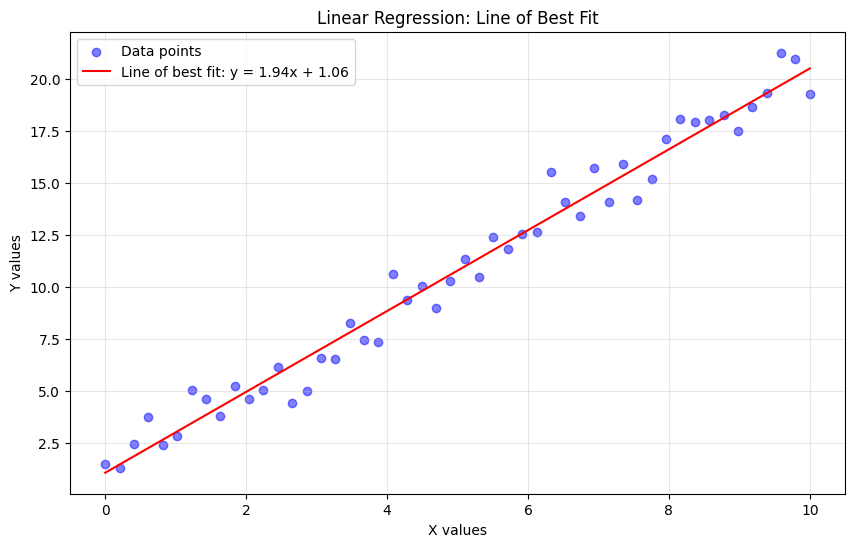

In [10]:
from IPython.display import display, Image

# Run the code with the CSV file
response = code_interpreter.run(
    code=code_to_plot,
    language="python",
    files=[csv_file],
)

# show results results
print(f"Status: {response.data.status}")
for output in response.data.outputs:
  if output.type == "stdout":
    print(f"{output.type}: {output.data}")
  elif output.type == "display_data":
    print(f"{output.type}: ")
    decoded_image = base64.b64decode(output.data['image/png'])
    display(Image(data=decoded_image))

if response.data.errors:
    print(f"Errors: {response.data.errors}")

The results show the printed output (`stdout`) from the script, including the data preview and regression statistics. Crucially, the plot generated by Matplotlib is captured as `display_data`. When an output is of type `display_data` (like plots), its `data` field often contains different representations (like `image/png`). Here, we decode the base64-encoded PNG image data and display it.

To learn more about Together Code Interpreter see [docs here](https://docs.together.ai/docs/together-code-interpreter-beta)!